# Library

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib notebook
%matplotlib inline

#### MTCNN (Face Detection)

In [4]:
from mtcnn.mtcnn import MTCNN

## Constants

In [41]:
VIDEO_NAME = 'friends.mp4'
VIDEO_OUTPUT = 'friends_output.mp4'
FONT = cv2.FONT_HERSHEY_COMPLEX_SMALL
RECTANGLE_COLOR_MTCNN = (0,128,0)  # GREEN    BGR
RECTANGLE_COLOR_HAAR = (255,0,0)   # BLUE
DISTANCE_TRIPLET_LOSS = 1.1


## Watch the video

In [ ]:
#This is the input video that will be proccesed
from IPython.display import HTML
import io, base64

video = io.open(VIDEO_NAME, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls> 
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

## FACE DETECTION (MTCNN)
#### Additionally this method is compared with OpenCV (Haar)

In [17]:
#HAAR
def process_frame(img, face_cascade):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    PADDING = 0
    
    identities = []
    for (x, y, w, h) in faces:
        x1 = x - PADDING
        y1 = y - PADDING
        x2 = x + w + PADDING
        y2 = y + h + PADDING

        img = cv2.rectangle(img, (x1, y1), (x2, y2), RECTANGLE_COLOR_HAAR, 2)
        cv2.putText(img," ("+str(w)+", "+str(h)+")",(x1,max(1,y1-3)), FONT, 0.5,(255,255,255),1,cv2.LINE_AA)

    return img

In [18]:
def processVideo(VIDEO_NAME, mtcnn=True, haar=True):
    detector = MTCNN()
    cap = cv2.VideoCapture(VIDEO_NAME)
    frames = []
    cnt = 0
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    print("length: ",length," ,width: ",width," ,height: ",height," ,fps: ",fps)

    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            print ("End of the video.")
            break;

        if mtcnn:
            results = detector.detect_faces(frame)
        if haar:
            frame = process_frame(frame, face_cascade)
            
        if mtcnn:
            if len(results)>0:
                for i in range(len(results)):
                    x1, y1, width, height = results[i]['box']
                    x1, y1 = abs(x1), abs(y1)
                    x2, y2 = x1 + width, y1 + height
                    cv2.rectangle(frame, (x1, y1), (x2, y2),  RECTANGLE_COLOR_MTCNN  , 2)
                    cv2.putText(frame,str(round(results[i]['confidence'],3))+" ("+str(width)+", "+str(height)+")",(x1,max(1,y1-3)), FONT, 0.5,(255,255,255),1,cv2.LINE_AA)
                    cv2.circle(frame,results[i]['keypoints']['left_eye'], 2, (0,255,0), -1)
                    cv2.circle(frame,results[i]['keypoints']['right_eye'], 2, (0,255,0), -1)
                    cv2.circle(frame,results[i]['keypoints']['nose'], 2, (0,255,0), -1)
                    cv2.circle(frame,results[i]['keypoints']['mouth_left'], 2, (0,255,0), -1)
                    cv2.circle(frame,results[i]['keypoints']['mouth_right'], 2, (0,255,0), -1)
        cv2.imshow('frames ',frame)
        cnt = cnt +1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [14]:
#Press key 'q' to Exit the video
#Rectangle Green (obtained by MTCNN),  Rectangle Blue (obtained by HAAR) 
processVideo(VIDEO_NAME,haar=False,mtcnn=True)

length:  6114  ,width:  1280  ,height:  720  ,fps:  23.97602449836772


In [19]:
# If you want to test, face detection in your webcam
processVideo(0)

length:  -1  ,width:  640  ,height:  480  ,fps:  30.0


# Face Recognition - FaceNet

#### Loading the model

In [21]:
from keras.models import model_from_json
from inception_resnet_v1 import *
model = InceptionResNetV1()
model.load_weights('facenet_weights.h5')
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

In [22]:
import os
from PIL import Image

In [23]:
#Given a file path, first we detect the face in the image with MTCNN and resize to (160,160,3)
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [24]:
#Saving in memory labels and faces in our database (./database)
def load_database(path='./database'):
    face = []
    label = []
    for files in os.listdir(path):
        face.append(extract_face(os.path.join(path,files)))
        label.append(files.split(".")[0])
    
    return np.asarray(face),label

In [25]:
database,label = load_database()

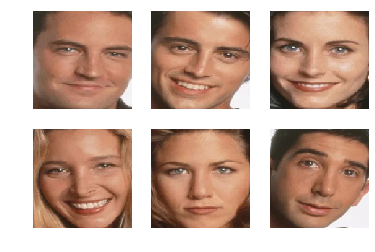

In [29]:
#PRINT IMAGES IN ./database WITH MTCNN
for i in range(len(label) ):
  plt.subplot(2, 3, i+1)
  plt.axis('off')
  plt.imshow(database[i])

plt.show()

In [32]:
#Given a face (previously preprocessed by MTCNN) Get Embedding with FACENET
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [33]:
#GEt the embedding in the path './dabatase'
from sklearn.preprocessing import Normalizer

database_embed = []
in_encoder = Normalizer(norm='l2')
for x in database:
    database_embed.append(get_embedding(model, x))
database_embed =  np.asarray(database_embed)
print(database_embed.shape)
database_embed = in_encoder.transform(database_embed)

(6, 128)


In [51]:
def processVideoRecognition(VIDEO_NAME, Write = False):
    detector = MTCNN()
    cap = cv2.VideoCapture(VIDEO_NAME)
    frames = []
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    print("length: ",length," ,width: ",width," ,height: ",height," ,fps: ",fps)
    cnt = 1
    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            print ("End of the video.")
            break;

        results = detector.detect_faces(frame)
        if len(results)>0:
            for i in range(len(results)):
                x1, y1, width, height = results[i]['box']
                x1, y1 = abs(x1), abs(y1)
                x2, y2 = x1 + width, y1 + height
                    
                detected_face = frame[int(y1):int(y1+height), int(x1):int(x1+width)] #crop detected face
                detected_face = cv2.cvtColor(detected_face, cv2.COLOR_RGB2BGR);
                detected_face = cv2.resize(detected_face, (160, 160)) 
                detected_face =  np.array(detected_face)
                embed = get_embedding(model, detected_face)
                embed =  np.asarray(embed)
                embed = np.expand_dims(embed, axis=0)
                embed = in_encoder.transform(embed)
                    
                mindist=100
                label_person= '' #Not found
                    
                for j in range(database.shape[0]):
                    dist = np.linalg.norm(embed - database_embed[j])
                    if dist<DISTANCE_TRIPLET_LOSS and mindist>dist:
                        mindist=dist
                        label_person= label[j]
                    
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0,128,0), 2)
                cv2.putText(frame,label_person,(x1,max(1,y1-20)), FONT, 0.5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(frame,str(round(results[i]['confidence'],3))+" ("+str(width)+", "+str(height)+")",(x1,max(1,y1-3)), FONT, 0.5,(255,255,255),1,cv2.LINE_AA)
                cv2.circle(frame,results[i]['keypoints']['left_eye'], 2, (0,255,0), -1)
                cv2.circle(frame,results[i]['keypoints']['right_eye'], 2, (0,255,0), -1)
                cv2.circle(frame,results[i]['keypoints']['nose'], 2, (0,255,0), -1)
                cv2.circle(frame,results[i]['keypoints']['mouth_left'], 2, (0,255,0), -1)
                cv2.circle(frame,results[i]['keypoints']['mouth_right'], 2, (0,255,0), -1)
        cv2.imshow('frames ',frame)
        if Write == True:
            name = 'frames/{0}.jpg'.format(cnt)
            cv2.imwrite(name, frame)
            cnt += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [43]:
processVideoRecognition(VIDEO_NAME)

length:  6114  ,width:  1280  ,height:  720  ,fps:  23.97602449836772


In [38]:
#Put your photo in the path './database', and check with your webcam
# run again, database,label = load_database() and get the embedding, to refresh changes ;)
processVideoRecognition(0)

length:  -1  ,width:  640  ,height:  480  ,fps:  30.0


# Additionally we will save the video
### We will create the video from images

In [49]:
import os
#create the folder "./frames/"
if not os.path.exists("./frames"):
    os.makedirs('frames')

In [53]:
processVideoRecognition(VIDEO_NAME, Write = True)

length:  6114  ,width:  1280  ,height:  720  ,fps:  23.97602449836772
End of the video.


In [54]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [55]:
import glob,os

VIDEO_SAVE_DIR = 'frames'
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[-1][:-3]))
outvid = os.path.join('./', VIDEO_OUTPUT)
make_video(outvid, images, fps=24)

<VideoWriter 000001FAC2D09470>